In [1]:
# general
import pandas as pd
import numpy as np
import os
import csv

# visualizations
import matplotlib.pyplot as plt

# NLP
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob

# modeling
import gensim
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
%matplotlib inline

In [2]:
# define houses
houses = ['gryffindor', 'ravenclaw', 'hufflepuff', 'slytherin']
primary_colors = ['#ae0001','#222f5b','#ecb939','#2a623d']
secondary_colors = ['#eeba30','#5d5d5d','#726255','#aaaaaa']

In [3]:
""" 
    make a dataframe that contains the chapters, textblobs of the chapters,
    houses, frequency per chapter and polarity per chapter
"""
files_dir = '/home/brendanfitzpatrick/Metis/projects/05-kojak/.gitignore/files/books/'
column_names = ['chapter','text','book_name','book_number']
df = pd.DataFrame(columns = column_names)
for filename in sorted(os.listdir(files_dir)):
    temp = pd.read_csv(files_dir+filename,header=None,names=['chapter','text'])
    temp['book_name'] = str(filename[2:-4])
    temp['book_number'] = int(filename[0:1])
    df = pd.concat([df, temp])
df = df[df.chapter.isnull()==False]
df['textblob'] = df.text.apply(lambda x: TextBlob(x))
df['house_counts_GRHS'] = df.textblob.apply(lambda x: [x.words.count(y) for y in houses])
df['chapter_polarity'] = df.textblob.apply(lambda x: x.sentiment.polarity)

In [ ]:
df.head()

# NLTK / TextBlob

In [ ]:
# make a textblob of all seven books combined, stemmed and with stop words removed
full_text = ''
stop = stopwords.words('english')
stop+=['?','!','.',',',':',';','n\'t','s','said']
stop = set(stop)
stemmer = nltk.stem.porter.PorterStemmer()
for index,row in df.iterrows():
    words = TextBlob(stemmer.stem(row.text)).words
    words = [w for w in words if w not in stop]
    full_text+=' '.join(words)
hp_full = TextBlob(full_text)

In [ ]:
words = []
counts = []
for word, count in sorted(hp_full.word_counts.items(), key=lambda x: x[1], reverse=True)[0:15]:
    words+=[word]
    counts+=[count]
    print("%15s %i" % (word, count))

In [ ]:
y_pos = np.arange(len(words))
plt.barh(y_pos,counts,align="center",alpha=0.5)
plt.yticks(y_pos,words)
plt.show()

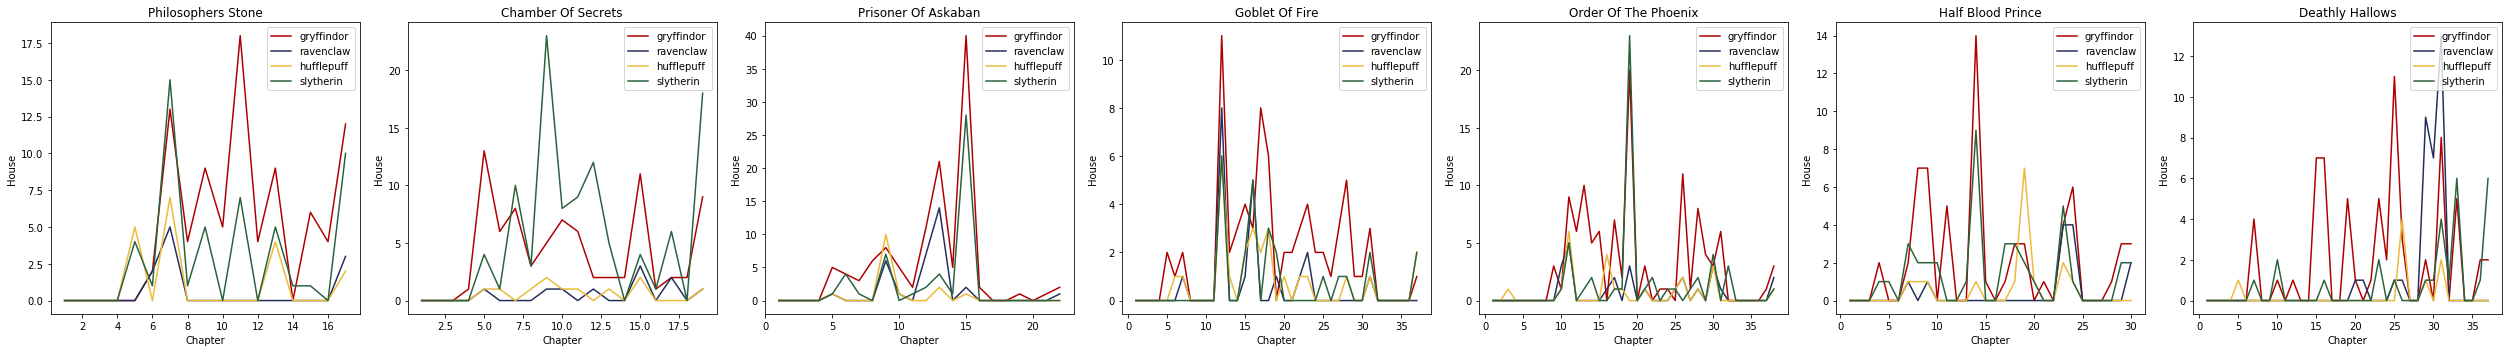

In [8]:
# plots of house mentions per chapter by book
book_titles=list(df.book_name.unique())
for i in range(len(book_titles)):
    book_titles[i] = book_titles[i].replace('_',' ').title()
    
df['house_counts_GRHS'] = df.textblob.apply(lambda x: [x.words.count(y) for y in houses])
fig, ax = plt.subplots(4,2,figsize=(35,5))
for book in range(1,8):
    ax[book-1].set(xlabel='Chapter',ylabel='House',title=book_titles[book-1])
    for house_count in range(len(houses)):
        x = df[df.book_number==book].chapter
        y = df[df.book_number==book].house_counts_GRHS.apply(lambda x: x[house_count])
        ax[book-1].plot(x,y,color = primary_colors[house_count],label=houses[house_count])
        ax[book-1].legend(loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
# create a dataframe of sentences for sentiment analysis
columns = ['sentence','chapter','book']
sentences = pd.DataFrame(columns=columns)
for index,row in df.iterrows():
    temp = pd.DataFrame(row.textblob.raw_sentences)
    temp['chapter'] = row.chapter
    temp['book'] = row.book_number
    temp.columns = columns
    sentences = pd.concat([sentences, temp])
sentences['sentiment'] = sentences.sentence.apply(lambda x: TextBlob(x).sentiment.polarity)

# sentiment analysis on sentences that contain house names
for house in houses:
    sentences[str(house)+'_polarity'] = sentences.sentence.apply(lambda x: np.NAN if house.title() not in x else TextBlob(x).sentiment.polarity)

# reset index and add one-based index sentence number
sentences.reset_index(inplace=True)
sentences['sentence_number']= pd.DataFrame(sentences.index).apply(lambda x: x+1)
sentences.drop('index',axis=1,inplace=True)

In [ ]:
# Percentage of Sentences House Names
sentences[(sentences.gryffindor_polarity.notnull()) | 
          (sentences.ravenclaw_polarity.notnull()) | 
          (sentences.hufflepuff_polarity.notnull()) | 
          (sentences.slytherin_polarity.notnull())].shape[0]/sentences.shape[0]

In [ ]:
# get the middle sentence number of each book for graphing purposes
median_sentences_per_book = []
for book in range(1,8):
    median_sentences_per_book+=[sentences[sentences.book==book].sentence_number.max()/2]

In [ ]:
median_sentences_per_book

In [ ]:
# plot sentiment on one graph
window = 2500
plt.figure(1)
for i in range(len(houses)):
    # this piece of code is very sentence to the location of the columns because of the iloc call
    plt.subplot(111)
    plt.plot(sentences.sentence_number,
                    sentences.iloc[:,4+i].interpolate().rolling(window=window,center=True).mean(),
                    color = primary_colors[i],
                    label=houses[i])
plt.suptitle("Polarity By House",fontweight='bold')
ax = plt.gca()
ax.set(xlabel='Sentence',ylabel='Sentiment')
ax.set_xlim(0,sentences.shape[0])
ax.set_ylim(-.5,.5)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.legend()
plt.show()

In [ ]:
x_labels=list(df.book_name.unique())
for i in range(len(x_labels)):
    x_labels[i] = x_labels[i].replace('_',' ').title()

In [ ]:
x_labels

In [ ]:
x_ticks = []
for book in range(1,8):
    x_ticks+=[(sentences[sentences.book==book].sentence_number.max()+sentences[sentences.book==book].sentence_number.min())/2]
x_labels=['Philosophers\nStone',
 'Chamber Of\nSecrets',
 'Prisoner\nOf Askaban',
 'Goblet\nOf Fire',
 'Order Of\nThe Phoenix',
 'Half Blood\nPrince',
 'Deathly\nHallows']
fig, ax = plt.subplots(2,2,figsize=(32,18))
window=2500
plt.rcParams.update({'font.size': 22})
fig.suptitle('Sentiment By House',fontweight='bold',color='gray',size=2
for i in range(len(houses)):
    if(i<=1):
        j = 0
    else:
        j = 1
    ax[i%2,j].set(xlabel='Sentence',ylabel='Sentiment')
    ax[i%2,j].set_xlim(0,sentences.shape[0])
    ax[i%2,j].set_ylim(-.75,.75)
    ax[i%2,j].set_xticks(x_ticks)
    ax[i%2,j].set_xticklabels(x_labels,rotation=45,ha='center')
    ax[i%2,j].xaxis.label.set_color('gray')
    ax[i%2,j].yaxis.label.set_color('gray')
    ax[i%2,j].tick_params(axis='x', colors='gray',size=10)
    ax[i%2,j].tick_params(axis='y', colors='gray')
    for tick in ax[i%2,j].xaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    # this piece of code is very sentence to the location of the columns because of the iloc call
    ax[i%2,j].plot(sentences.sentence_number,
                    sentences.iloc[:,4+i].interpolate().rolling(window=window,center=True).mean(),
                    color = primary_colors[i],
                    label=(houses[i].title()))
    #ax[i%2,j].legend(color='gray')
    leg = ax[i%2,j].legend()
    for text in (leg.get_texts()):
        text.set_color('gray')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
t = np.arange(0.0, 2.0, 0.01)
s1 = np.sin(2*np.pi*t)
s2 = np.sin(4*np.pi*t)

plt.figure(1)
plt.subplot(211)
plt.plot(t, s1)

plt.figure(1)
plt.subplot(211)
plt.plot(t, s2, 's')
ax = plt.gca()
ax.set_xticklabels([])

plt.show()

In [ ]:
"""
# plots sentiment per sentence by book
fig, ax = plt.subplots(7, 1, figsize=(5,20))
for book in range(1,8):
    x = sentences[sentences.book==book].index
    y = sentences[sentences.book==book].sentiment
    ax[book-1].scatter(x,y)
    ax[book-1].set(xlabel='Sentence',ylabel='Sentiment',title='Book '+str(book))
plt.show()
"""

In [ ]:
# overall sentiment analysis per book
fig, ax = plt.subplots(7, 1, figsize=(5,20))
for book in range(1,8):
    x = df[df.book_number==book].chapter
    y = df[df.book_number==book].chapter_polarity
    ax[book-1].plot(x,y)
    ax[book-1].set(xlabel='Chapter',ylabel='Sentiment',title='Book '+str(book))
    ax[book-1].set_ylim(-1,1)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(5,5))
for i in range(len(houses)):
    if(i<=1):
        j = 0
    else:
        j = 1
    ax[i%2, j].set(xlabel='Sentence',ylabel='Sentiment',title=houses[i])
    ax[i%2, j].set_xlim(0,sentences.shape[0])
    ax[i%2, j].set_ylim(-1,1)
    # this piece of code is very sentence to the location of the columns because of the iloc call
    ax[i%2, j].plot(sentences[(sentences.gryffindor_polarity.notnull()) | 
                      (sentences.ravenclaw_polarity.notnull()) | 
                      (sentences.hufflepuff_polarity.notnull()) | 
                      (sentences.slytherin_polarity.notnull())].sentence_number,
               sentences[(sentences.gryffindor_polarity.notnull()) | 
                      (sentences.ravenclaw_polarity.notnull()) | 
                      (sentences.hufflepuff_polarity.notnull()) | 
                      (sentences.slytherin_polarity.notnull())].iloc[:,4+i],
              color = primary_colors[i],
              label=houses[i])
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
window = 2500
for i in range(len(houses)):
    # this piece of code is very sentence to the location of the columns because of the iloc call
    plt.plot(sentences.sentence_number,
             sentences.iloc[:,4+i].fillna(sentences.iloc[:,4+i].mean()).rolling(window=window,center=True).mean(),
             color = primary_colors[i],
             label=houses[i])
plt.suptitle("Polarity By House",fontweight='bold')
plt.set(xlabel='Sentence',ylabel='Sentiment')
plt.set_xlim(0,sentences.shape[0])
plt.set_ylim(-.5,.5)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.legend()
plt.show()

In [ ]:
median_sentences_per_book = []
for book in range(1,8):
    median_sentences_per_book+=[sentences[sentences.book==book].sentence_number.max()/2]

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(5,5))
window=1000
fig.suptitle('NAN Interpolation: '+str(window)+' Element Window',fontweight='bold')
for i in range(len(houses)):
    if(i<=1):
        j = 0
    else:
        j = 1
    ax[i%2, j].set(xlabel='Sentence',ylabel='Sentiment',title=houses[i])
    ax[i%2, j].set_xlim(0,sentences.shape[0])
    ax[i%2, j].set_ylim(-.75,.75)
    # this piece of code is very sentence to the location of the columns because of the iloc call
    ax[i%2, j].plot(sentences.sentence_number,
                    sentences.iloc[:,4+i].interpolate().rolling(window=window,center=True).mean(),
                    color = primary_colors[i],
                    label=houses[i])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(5,5))
window=2500
fig.suptitle('NAN Interpolation: '+str(window)+' Element Window',fontweight='bold')
for i in range(len(houses)):
    if(i<=1):
        j = 0
    else:
        j = 1
    ax[i%2, j].set(xlabel='Sentence',ylabel='Sentiment',title=houses[i])
    ax[i%2, j].set_xlim(0,sentences.shape[0])
    ax[i%2, j].set_ylim(-.75,.75)
    # this piece of code is very sentence to the location of the columns because of the iloc call
    ax[i%2, j].plot(sentences.sentence_number,
                    sentences.iloc[:,4+i].interpolate().rolling(window=window,center=True).mean(),
                    color = primary_colors[i],
                    label=houses[i])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(5,5))
window=2500
fig.suptitle('NAN Interpolation: '+str(window)+' Element Window',fontweight='bold')
for i in range(len(houses)):
    if(i<=1):
        j = 0
    else:
        j = 1
    ax[i%2, j].set(xlabel='Sentence',ylabel='Sentiment',title=houses[i])
    ax[i%2, j].set_xlim(0,sentences.shape[0])
    ax[i%2, j].set_ylim(-.75,.75)
    # this piece of code is very sentence to the location of the columns because of the iloc call
    ax[i%2, j].plot(sentences.sentence_number,
                    sentences.iloc[:,4+i].interpolate().rolling(window=window,center=True).mean(),
                    color = primary_colors[i],
                    label=houses[i])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(5,5))
window=5000
fig.suptitle('NAN Interpolation: '+str(window)+' Element Window',fontweight='bold')
for i in range(len(houses)):
    if(i<=1):
        j = 0
    else:
        j = 1
    ax[i%2, j].set(xlabel='Sentence',ylabel='Sentiment',title=houses[i])
    ax[i%2, j].set_xlim(0,sentences.shape[0])
    ax[i%2, j].set_ylim(-.5,.5)
    # this piece of code is very sentence to the location of the columns because of the iloc call
    ax[i%2, j].plot(sentences.sentence_number,
                    sentences.iloc[:,4+i].interpolate().rolling(window=window,center=True).mean(),
                    color = primary_colors[i],
                    label=houses[i])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(5,5))
window=2500
fig.suptitle('NAN Ffill: '+str(window)+' Element Window',fontweight='bold')
for i in range(len(houses)):
    if(i<=1):
        j = 0
    else:
        j = 1
    ax[i%2, j].set(xlabel='Sentence',ylabel='Sentiment',title=houses[i])
    ax[i%2, j].set_xlim(0,sentences.shape[0])
    ax[i%2, j].set_ylim(-.75,.75)
    # this piece of code is very sentence to the location of the columns because of the iloc call
    ax[i%2, j].plot(sentences.sentence_number,
                    sentences.iloc[:,4+i].ffill().rolling(window=window,center=True).mean(),
                    color = primary_colors[i],
                    label=houses[i])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(5,5))
window=2500
fig.suptitle('NAN Bfill: '+str(window)+' Element Window',fontweight='bold')
for i in range(len(houses)):
    # this piece of code is very sentence to the location of the columns because of the iloc call
    if(i<=1):
        j = 0
    else:
        j = 1
    ax[i%2, j].set(xlabel='Sentence',ylabel='Sentiment',title=houses[i])
    ax[i%2, j].set_xlim(0,sentences.shape[0])
    ax[i%2, j].set_ylim(-.75,.75)
    # this piece of code is very sentence to the location of the columns because of the iloc call
    ax[i%2, j].plot(sentences.sentence_number,
                    sentences.iloc[:,4+i].bfill().rolling(window=window,center=True).mean(),
                    color = primary_colors[i],
                    label=houses[i])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# TDIDF

In [ ]:
# tfidf functions
def tf(word, blob):
    return blob.words.count(word) / len(blob.words)

def n_containing(word, bloblist):
    return sum(1 for blob in bloblist if word in blob.words)

def idf(word, bloblist):
    return math.log(len(bloblist) / (1 + n_containing(word, bloblist)))

def tfidf(word, blob, bloblist):
    return tf(word, blob) * idf(word, bloblist)

# Word2Vec

In [ ]:
# create preprocessing iterable

stop2 = stopwords.words('english')
stop2+=['?','!','.',',',':',';']

class MySentences(object):
    # a memory-friendly way to load a large corpora
     def __init__(self, dirname):
            self.dirname = dirname
 
     def __iter__(self):
        # iterate through all file names in our directory
         for fname in os.listdir(self.dirname):
                for line in open(os.path.join(self.dirname, fname), encoding="ISO-8859-1"):
                    word=line.lower().split()
                    if word not in stop2:
                        yield word

In [ ]:
sentence_iter = MySentences('/home/brendanfitzpatrick/Metis/projects/05-kojak/.gitignore/files/superseded')
model = gensim.models.Word2Vec(sentence_iter,size=100,min_count=3,workers=4)

In [ ]:
model.most_similar('hufflepuff',topn=10)

In [ ]:
model.most_similar('gryffindor',topn=10)

In [ ]:
model.most_similar('slytherin',topn=10)

In [ ]:
model.most_similar('ravenclaw',topn=10)

# Dimension Reduction using PCA and T-SNE

In [ ]:
labels = []
tokens = []
for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)

In [ ]:
pca = PCA(n_components=50)

In [ ]:
X_pca = pca.fit_transform(tokens)

In [ ]:
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

In [ ]:
# word number sanity check
print('Token rows:\t'+str(len(tokens)) +'\n'+
      'PCA Model Rows:\t'+str(len(X_pca)))

In [ ]:
tsne_model = TSNE(perplexity=40,
                  n_components=2,
                  init='pca',
                  n_iter=2500,
                  random_state=2
                 )

In [ ]:
X_tsne = tsne_model.fit_transform(X_pca)

In [ ]:
x = []
y = []
for value in X_tsne:
    x.append(value[0])
    y.append(value[1])

In [ ]:
plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2), 
                 textcoords='offset points', 
                 ha='right',
                 va='bottom'
                )
plt.show()

In [ ]:
print("X :\t"+str(len(x))+'\nY:\t'+str(len(y))+'\nLabels:\t'+str(len(labels)))

In [ ]:
visualizations = pd.DataFrame(
    {
        'X': x,
        'Y': y,
        'Labels': labels
    }
)

In [ ]:
visualizations.to_csv('/home/brendanfitzpatrick/Metis/projects/05-kojak/.gitignore/files/visualization_pca.csv',index=False)

In [ ]:
visualizations.head()

In [ ]:
!head -10 '/home/brendanfitzpatrick/Metis/projects/05-kojak/.gitignore/files/visualization_pca.csv'